<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/SatelliteSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

## Imports

In [ ]:
import os, datetime, math
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from seaborn import heatmap
from sklearn.utils import class_weight
from matplotlib import cm
from matplotlib.patches import Patch

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

In [ ]:
# only run on colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline

## Global parameters

In [ ]:
# paths
PATH = '/content/drive/MyDrive/Colab Notebooks/satellite-segmentation/data/'

# use gpu if possible
TASK = 'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'

# set the pixel to extract
PIXEL_X = 16
PIXEL_Y = 16

# training iterations
ITERS = 2000

# random seed
SEED = 42

## Load data

In [ ]:
data = np.load(f'{PATH}train.npz')['bands']
labels = np.load(f'{PATH}train.npz')['lulc']

test = np.load(f'{PATH}public_test.npz')['bands']

classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])

## Preprocessing

In [ ]:
def preprocess(x, y, labels=None):
  x = x[y != 0, :, :, :, :] if labels == 'exclude_no_data' else x[y == 0, :, :, :, :] if labels == 'only_no_data' else x
  y = y[y != 0] if labels == 'exclude_no_data' else y[y == 0] if labels == 'only_no_data' else y

  x_train, x_val, y_train, y_val = train_test_split(x[:, :, PIXEL_X, PIXEL_Y, :].reshape((x.shape[0], x.shape[1] * x.shape[-1])), y, test_size=0.2, random_state=42, stratify = y)

  return x_train, x_val, y_train, y_val

## Exploratory Data Analysis?

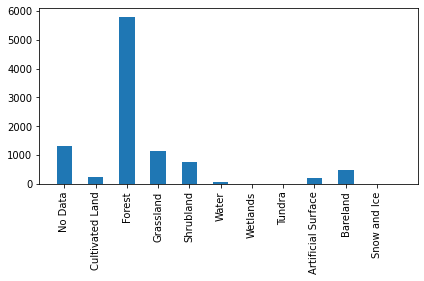

In [ ]:
plt.hist(labels, bins=list(range(len(classes) + 1)), width=0.5, align='mid')
plt.xticks(ticks=[i + 0.25 for i in range(len(classes))], labels=classes, rotation=90)
plt.tight_layout()
plt.show()

# Semi-Supervised Learning

## Training with only labelled data

In [ ]:
# use only labelled data for training
x_train, x_val, y_train, y_val = preprocess(data, labels, 'exclude_no_data')
f'train: {x_train.shape} {y_train.shape}, validation: {x_val.shape} {y_val.shape}'

'train: (6953, 72) (6953,), validation: (1739, 72) (1739,)'

In [ ]:
cbm = CatBoostClassifier(learning_rate=0.1, iterations=ITERS, random_seed=SEED, logging_level='Silent', task_type=TASK)
# fit on labelled data
cbm.fit(x_train, y_train)

In [ ]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

In [ ]:
# fit the model on full labelled data, i. e. combine the splits
cbm.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))

## Predict labels for unlabelled data

In [ ]:
# predict labels for unlabelled data
unlabelled_data_transformed = data[labels == 0, :, PIXEL_X, PIXEL_Y, :].reshape((data.shape[0], data.shape[1] * data.shape[-1]))
predicted_labels = cbm.predict(unlabelled_data_transformed).reshape(-1)

In [ ]:
# train the model on labelled training instances and add predicted labels
x_train = np.concatenate((x_train, unlabelled_data_transformed))
y_train = np.concatenate((y_train, predicted_labels))
cbm.fit(x_train, y_train)

In [ ]:
# evaluate the model
cbm_train = cbm.predict(x_train).reshape(-1)
cbm_val = cbm.predict(x_val).reshape(-1)

print('Training\n')
print(f'Accuracy: {accuracy_score(y_train, cbm_train)*100}')
print(f'F1-Score: {f1_score(y_train, cbm_train, average=None)*100}')
print(classification_report(y_train, cbm_train))

print('\n')

print('Validation\n')
print(f'Accuracy: {accuracy_score(y_val, cbm_val)*100}')
print(f'F1-Score: {f1_score(y_val, cbm_val, average=None)*100}')
print(classification_report(y_val, cbm_val))

In [ ]:
# confusion matrix
preds = cbm_val
preds_df = pd.DataFrame({'true':y_val, 'preds':preds})
conf_df = pd.DataFrame(confusion_matrix(preds_df['true'], preds_df['preds']), index=classes[np.unique(preds)], columns=classes[np.unique(preds)])
heatmap(conf_df, annot=True, fmt='d', cbar=False)

plt.tight_layout()
plt.show()

## Full fit with only labelled data

In [ ]:
# final step: fit the model on all labelled data
labelled_data_transformed = data[labels != 0, :, PIXEL_X, PIXEL_Y, :].reshape((data.shape[0], data.shape[1] * data.shape[-1]))
labelled_data_labels = labels[labels != 0]
cbm.fit(labelled_data_transformed, labelled_data_labels)

## Full prediction of labels

In [ ]:
# predict labels for unlabelled data
unlabelled_data_transformed = data[labels == 0, :, PIXEL_X, PIXEL_Y, :].reshape((data.shape[0], data.shape[1] * data.shape[-1]))
predicted_labels = cbm.predict(unlabelled_data_transformed).reshape(-1)

# overwrite existing labels without label
new_labels = labels.copy()
new_labels[labels == 0] = predicted_labels

## Fit final model on full data

In [ ]:
# fit model with full data
full_data_transformed = data[:, :, PIXEL_X, PIXEL_Y, :].reshape((data.shape[0], data.shape[1] * data.shape[-1]))
cbm.fit(full_data_transformed, new_labels)

# Results

## Metrics

## Visualization

In [ ]:
test_transformed = []
for i in range(500):
  for j in range(500):
    pixel = test[:, i, j, :].reshape((72,))
    test_transformed.append(pixel)

test_transformed = np.array(test_transformed)

pred = cbm.predict(test_transformed).reshape((500, 500))

In [ ]:
# plot image and predicted labels
month = 3

f, (sat, lulc) = plt.subplots(1, 2, figsize=(20,10), dpi=96, tight_layout=True)

band = 0.5 + 2.5 * (np.flip(test[month, :, :, :3], -1) + .3 - 0.5)
sat.imshow(band, cmap='gray')
sat.set_title(f'Test image\nSize: 500 x 500\nMonth: {month}')

im = lulc.imshow(pred)
colors = [im.cmap(im.norm(value)) for value in np.unique(pred).astype(int)]
portions = np.array([round(x, 2) for x in np.histogram(pred, bins=range(len(classes)))[0] / pred.shape[0] ** 2 * 100])[np.unique(pred).astype(int)]
patches = [Patch(color=colors[i], label=f'{portions[i]}% {classes[np.unique(pred).astype(int)[i]]}') for i in range(len(np.unique(pred).astype(int)))]

lulc.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
lulc.set_title(f'Model: CatBoostClassifier \n Iterations: {ITERS}\nValidation accuracy: {accuracy_score(y_val, cbm_val)*100}%')

plt.show()

## Export

In [ ]:
# save plot, model and predictions
f.savefig(f'{PATH}plot.png')
np.save(f'{PATH}predictions.npy', pred)
cbm.save_model(f'{PATH}model')